In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
def draw_line(x, y, file_name = None, color = None, label = None, marker=None, markersize=None, linestyle=None, xlabel = None, ylabel = None,
                        xlim = None, xticks = None, ylim = None, yticks = None, log_x = False, log_y = False,
                        draw_legend = None, figsize=None, fig_per_line=None, 
                        linewidth=1, xticks_rotation=0, yticks_rotation=0, 
                        legend_fontsize_dec=0, legend_ncol=1, legend_loc=None, legend_figsize=None, baseline = None, 
                        zorder=None):

    scale_factor = 2

    fontsize = 5 * scale_factor
    legend_fontsize = (fontsize/scale_factor - legend_fontsize_dec) * scale_factor
    plt.rcParams.update({'font.size': fontsize})
    
    tickpad = 1.0 * scale_factor
    labelpad = 2.0 * scale_factor
    
    figurepad_inches = 0.02
    label_width_inches = 0.15
    tick_width_inches = 0.15
    
    A4w = 8.25 # inch
    A4h = 11.75
    lr_margin = 0.675
    m_margin = 0.15
    single_col_fig_w = (A4w - lr_margin * 2 - m_margin) / 2
    fig_h = (single_col_fig_w / 2 - label_width_inches - tick_width_inches) * 0.618
    cross_col_fig_w = A4w - lr_margin * 2
    if figsize != None:
        assert fig_per_line == None
    else :
        if fig_per_line == None:
            fig_per_line = 2
        if fig_per_line == 1:
            fig_w = cross_col_fig_w
        elif fig_per_line == 2:
            fig_w = single_col_fig_w
        elif fig_per_line == 3:
            fig_w = cross_col_fig_w / 3
        elif fig_per_line == 4:
            fig_w = single_col_fig_w / 2
        else:
            assert False
        # fig_w -= 0.15 * 2 # margin
        fig_w -= tick_width_inches # ticks
        if ylabel:
            fig_w -= label_width_inches # ylabel

        fig_w *= scale_factor
        fig_h *= scale_factor
        figsize = (fig_w, fig_h) 
    print(f"figsize = {figsize}")
    plt.figure(figsize=figsize)

    # brokenaxes(ylims = ((0, 100), (1000, 1200)))

    if log_x:
        plt.xscale("log", subs=[0]) # should set log before ticks
    if log_y:
        plt.yscale("log", subs=[0])
    
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])

    plt.tick_params(axis='both', which='both', direction='in')
    plt.tick_params(axis='y', pad=tickpad)
    if xticks != None:
        plt.xticks(xticks[0], xticks[1], rotation=xticks_rotation)
    if yticks != None:
        plt.yticks(yticks[0], yticks[1], rotation=yticks_rotation)

    plt.xlabel(xlabel, labelpad=labelpad)
    plt.ylabel(ylabel, labelpad=labelpad)
    
    # print(x_len, x)
    for i, (sub_x, sub_y) in enumerate(zip(x, y)):
        # print(yerr[i])
        plt.plot(sub_x, sub_y, linewidth=linewidth, color=color[i] if color is not None else None, label=label[i] if label is not None else None, 
                 marker=marker[i] if marker!=None else None, markersize=markersize[i] if marker!=None else None,
                 linestyle=linestyle[i] if linestyle!=None else None,
                zorder=zorder[i] if zorder!=None else None)

    
    if baseline:
        if xlim:
            min_x, max_x = xlim
        else:
            min_x = np.min([np.min(subx) for subx in x])
            max_x = np.max([np.max(subx) for subx in x])
        for base_y in baseline:
            plt.plot([min_x, max_x], [base_y, base_y], linewidth=1, color="#D0D0D0", linestyle="--", zorder=0.9)

    if draw_legend and draw_legend == "in":
        plt.legend(fontsize=legend_fontsize, framealpha=0.0, loc=legend_loc, ncol=legend_ncol)
            
    plt.savefig (file_name, dpi=200, bbox_inches = 'tight', pad_inches=figurepad_inches)
    plt.show()
    plt.close()
    
    if not (draw_legend and draw_legend == "out"):
        return

    assert legend_figsize != None
    plt.figure(figsize=legend_figsize)
    
    for i, (sub_x, sub_y) in enumerate(zip(x, y)):
        plt.plot([0], [0], linewidth=linewidth, color=color[i], label=label[i], 
                 marker=marker[i] if marker!=None else None, markersize=markersize[i] if marker!=None else None,
                 zorder=zorder[i] if zorder!=None else None) # zorder

    plt.legend(fontsize=legend_fontsize, loc="center left", framealpha=0.0, ncol=len(models))
    plt.axis('off')
    plt.savefig ("legend_"+file_name, dpi=200, bbox_inches = 'tight', pad_inches=figurepad_inches)
    plt.show()
    plt.close()


In [100]:
import json
with open('figure.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
conversation_round_cnt = data["conversation_round_cnt"]
conversation_len = data["conversation_len"]
round_prompt_len = data["round_prompt_len"]
round_new_prompt_len = data["round_new_prompt_len"]
round_response_len = data["round_response_len"]
seq_len_in_decode = data["seq_len_in_decode"]
prompt_lens = [seq_len_range[0] for seq_len_range in seq_len_in_decode]
response_lens = [seq_len_range[1]-seq_len_range[0] for seq_len_range in seq_len_in_decode]

for i, seq_len_range in enumerate(seq_len_in_decode):
    if seq_len_range[1] < seq_len_range[0]:
        raise Exception(f"seq_len_in_decode[{i}]={seq_len_in_decode[i]} is invalid")
        
conversation_round_cnt.sort()
conversation_len.sort()
round_prompt_len.sort()
round_new_prompt_len.sort()
round_response_len.sort()

max_seq_len = max([seq_len_range[1] for seq_len_range in seq_len_in_decode])
print(f"max_seq_len {max_seq_len}")
seq_len_cnt = np.zeros(max_seq_len + 2, dtype=np.int32)
seq_len_start = np.array(list(seq_len_range[0] for seq_len_range in seq_len_in_decode))
seq_len_end = np.array(list(seq_len_range[1] + 1 for seq_len_range in seq_len_in_decode))

# for i, seq_len_range in enumerate(seq_len_in_decode):
#     if seq_len_end[i] < seq_len_start[i]:
#         raise Exception(f"seq_len_in_decode[{i}]={seq_len_in_decode[i]} is invalid")
# print(seq_len_start)
counts_start = np.bincount(seq_len_start, minlength=len(seq_len_cnt))
seq_len_cnt += counts_start
print(np.sum(seq_len_cnt), len(seq_len_start))
counts_end = np.bincount(seq_len_end, minlength=len(seq_len_cnt))
seq_len_cnt -= counts_end
print(np.sum(seq_len_cnt), len(seq_len_end))
# print(seq_len_cnt[:100])
np.cumsum(seq_len_cnt, out=seq_len_cnt)

if np.any(seq_len_cnt < 0):
    print(seq_len_cnt[seq_len_cnt < 0])
    raise Exception()
# print(seq_len_cnt[:100])
seq_mem = seq_len_cnt * np.arange(1, len(seq_len_cnt) + 1)
# print(seq_mem[:100])
seq_mem_prefix_sum = seq_mem.cumsum()
seq_len_cnt_prefix_sum = seq_len_cnt.cumsum()
# print(seq_mem_prefix_sum[:100])
seq_mem_prefix_sum = seq_mem_prefix_sum.astype(np.float64) / seq_mem_prefix_sum[-1]
seq_len_cnt_prefix_sum = seq_len_cnt_prefix_sum.astype(np.float64) / seq_len_cnt_prefix_sum[-1]

print(len(conversation_round_cnt), len(conversation_len), len(round_prompt_len), len(round_new_prompt_len), len(round_response_len))

max_seq_len 457764
733551 733551
0 733551
90665 90665 719155 719155 733551


figsize = (6.15, 1.7149500000000002)


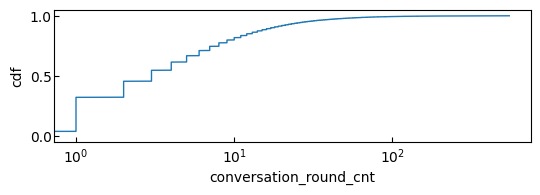

In [101]:
draw_line([conversation_round_cnt], [[y/len(conversation_round_cnt) for y in range(len(conversation_round_cnt))]], color = [None], label = [None], file_name = 'conversation_round_cnt.png',
          xlabel = 'conversation_round_cnt', log_x=1, ylabel = 'cdf')

figsize = (6.15, 1.7149500000000002)


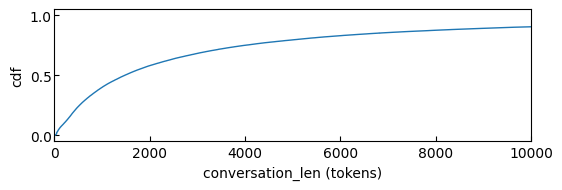

In [102]:
draw_line([conversation_len], [[y/len(conversation_len) for y in range(len(conversation_len))]], color = [None], label = [None], file_name = 'conversation_len.png',
          xlabel = 'conversation_len (tokens)', xlim = [0, 10000], ylabel = 'cdf')

[719155, 719155, 733551]
figsize = (6.15, 1.7149500000000002)


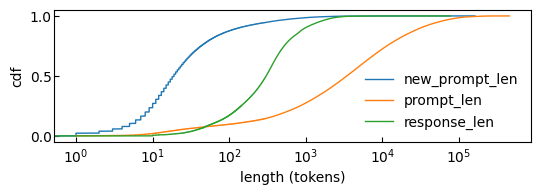

In [103]:
x_groups = [round_new_prompt_len, round_prompt_len, round_response_len]
print([len(xs) for xs in x_groups])
y_groups = [[y/len(xs) for y in range(len(xs))] for xs in x_groups]
draw_line(x_groups, y_groups, color = [None, None, None], label = ["new_prompt_len", "prompt_len", "response_len"], file_name = 'round_statistics.png',
          xlabel = 'length (tokens)', log_x=1, ylabel = 'cdf', draw_legend="in")

457766
figsize = (6.45, 1.7149500000000002)


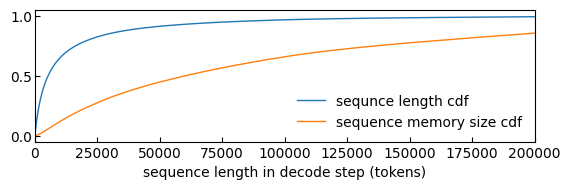

In [107]:
print(len(seq_mem_prefix_sum))
xlim = 200000
y_groups = [seq_len_cnt_prefix_sum, seq_mem_prefix_sum]
x_groups = [range(len(ys)) for ys in y_groups]
label = ["sequnce length cdf", "memory-weight sequence length cdf"]
draw_line(x_groups, y_groups, label = label, file_name = 'memory.png',
          xlabel = 'sequence length in decode step (tokens)', xlim=[None, xlim], draw_legend="in")

733551


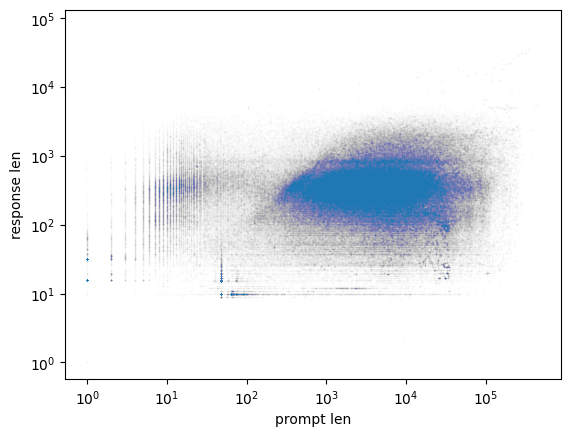

In [105]:
print(len(prompt_lens))
plt.xscale("log", subs=[0])
plt.yscale("log", subs=[0])
plt.xlabel("prompt len")
plt.ylabel("response len")
plt.scatter(prompt_lens, response_lens, s=1, alpha=0.002)
plt.show()